# Naive Bayes micro project - income prediction

By: Mathias Lund Ahrn

In [1]:
# code in this cell from: 
# https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to display/hide the code."></form>''')

## Introduction

This project will be looking into the 1994 census summary data to predict if income is lower or higher than $50,000 by using Naïve Bayes classifier. 

# Reading and preprocessing the data

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns
sns.set()
rcParams['figure.figsize'] = 8,6
sns.set_context('talk')
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import GaussianNB

from sklearn.linear_model import LogisticRegression

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/1994-census-summary.csv")

### First glance at the dataset

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 16 columns):
usid              32561 non-null int64
age               32561 non-null int64
workclass         30725 non-null object
fnlwgt            32561 non-null int64
education         32561 non-null object
education_num     32561 non-null int64
marital_status    32561 non-null object
occupation        30718 non-null object
relationship      32561 non-null object
race              32561 non-null object
sex               32561 non-null object
capital_gain      32561 non-null int64
capital_loss      32561 non-null int64
hours_per_week    32561 non-null int64
native_country    31978 non-null object
label             32561 non-null object
dtypes: int64(7), object(9)
memory usage: 4.0+ MB


In [5]:
print("Number of rows: {} \nNumber of columns: {}".format(df.shape[0], df.shape[1]))

Number of rows: 32561 
Number of columns: 16


Columns with missing data:
- workclass
- occupation
- native_country

Most of the columns are self-explainatory except for *usid*, *fnlwgt* and *label*. 
- *label* shows whether the income is below or above $50K. 
- *usid* and *fnlwgt* does not have any documentation of what it is, therefore these columns will be excluded in this project

Datatypes in this dataset are string and int.

Int columns:
- age
- education_num
- capital_gain
- capital_loss
- hours_per_week

String columns:
- workclass
- education
- marital_status
- occupation
- relationship
- race
- sex
- native_country
- label

### Data cleaning

Data cleaning is done with the following steps:
- Dropping columns `usid` and `fnlwgt`
- Dropping all rows where NA values are present

In [6]:
df = pd.read_csv("https://raw.githubusercontent.com/grbruns/cst383/master/1994-census-summary.csv")
# Dropping fnlwgt and usid
df.drop(columns=["usid", "fnlwgt"], inplace=True)

# Dropping all rows with missing data in following columns: workclass, occupation, native_country
df.dropna(axis=0, how='any', inplace=True)

In [7]:
df.isna().sum()

age               0
workclass         0
education         0
education_num     0
marital_status    0
occupation        0
relationship      0
race              0
sex               0
capital_gain      0
capital_loss      0
hours_per_week    0
native_country    0
label             0
dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30162 entries, 0 to 32560
Data columns (total 14 columns):
age               30162 non-null int64
workclass         30162 non-null object
education         30162 non-null object
education_num     30162 non-null int64
marital_status    30162 non-null object
occupation        30162 non-null object
relationship      30162 non-null object
race              30162 non-null object
sex               30162 non-null object
capital_gain      30162 non-null int64
capital_loss      30162 non-null int64
hours_per_week    30162 non-null int64
native_country    30162 non-null object
label             30162 non-null object
dtypes: int64(5), object(9)
memory usage: 3.5+ MB


Above is a verification of no NA values and both `usid` and `fnlwgt` are removed.

# Data exploration

#### How many have an income below or above $50,000?

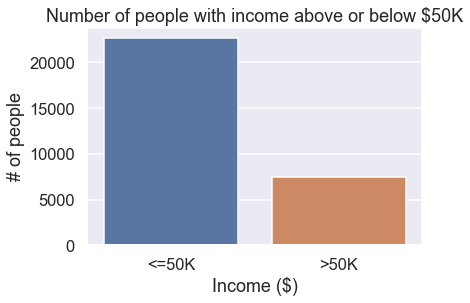

In [9]:
cp = sns.countplot(df["label"])
plt.title("Number of people with income above or below $50K")
plt.xlabel("Income ($)")
plt.ylabel("# of people")
plt.show(cp)

This plot shows there are roughly 23,000 people with income below \\$50,000 and roughly 7,000 people with income above \\$50,000.

#### What is the difference in income between male and female?

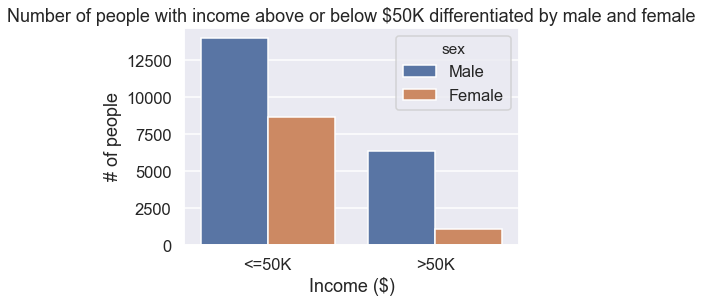

In [10]:
cp = sns.countplot(df["label"], hue=df["sex"])
plt.title("Number of people with income above or below $50K differentiated by male and female")
plt.xlabel("Income ($)")
plt.ylabel("# of people")
plt.show(cp)

With this chart we can see that alot higher percentage of men are earning more than \\$50K compared to women.

#### What ages are represented in the dataset?

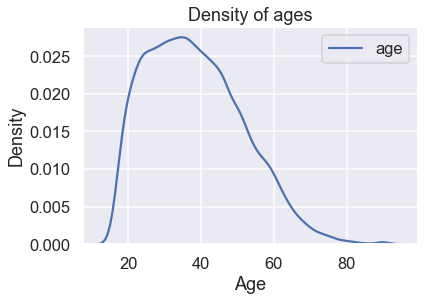

In [11]:
dp = sns.kdeplot(df["age"])
plt.title("Density of ages")
plt.xlabel("Age")
plt.ylabel("Density")
plt.show(dp)

The distribution of age in this dataset shows that most of the data are from age 22 to 50.

#### What types of job generates above or below \\$50K?

Are there any siginificant differences in type of job?

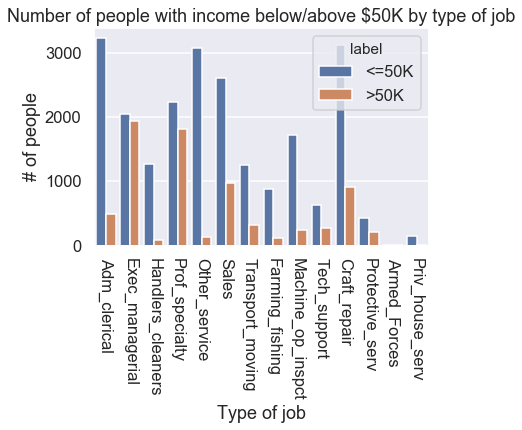

In [12]:
cp = sns.countplot(data=df, x="occupation", hue="label")
plt.title("Number of people with income below/above $50K by type of job")
plt.xlabel("Type of job")
plt.ylabel("# of people")
plt.xticks(rotation=-90)
plt.show(cp)

The graph shows that all type of jobs in this dataset have a salary rate below \\$50K. There are two job types that stands out where there are close to equal number of people with an income below or above \\$50K, which are in *Exec_managerial* and *Prof_speciality*.

For *Armed_Forces* and *Priv_house_serv* there isn't a lot of data recorded so by looking specifically for those two categories we can discover that for *Armed_Forces* there are 8 people with income below \\$50K and 1 person with an income above \\$50K.

In [13]:
df[df["occupation"] == "Armed_Forces"]["label"].value_counts()

<=50K    8
>50K     1
Name: label, dtype: int64

In the case of job type *Priv_house_serv* there are 142 people with an income below \\$50K and 1 person with an income above \\$50K.

In [14]:
df[df["occupation"] == "Priv_house_serv"]["label"].value_counts()

<=50K    142
>50K       1
Name: label, dtype: int64

#### Does race have an impact on income?

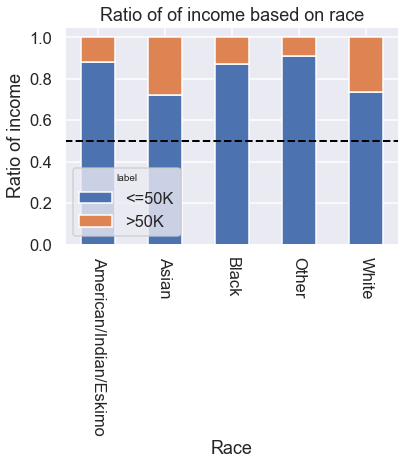

In [15]:
def calcIncome(x):
    return x.groupby("label").size()/x["race"].shape[0]


perc_inc = pd.DataFrame(df.groupby("race").apply(calcIncome))
perc_inc.rename({0:'<=50K', 1:'>50K'}, axis='columns', inplace=True)
races = ["American/Indian/Eskimo", "Asian", "Black", "Other", "White"]
ax = perc_inc.plot.bar(stacked=True);
ax.set_xticklabels([race for race in races], rotation=-90)
ax.set_title("Ratio of of income based on race")
ax.set_xlabel("Race")
ax.set_ylabel("Ratio of income")
ax.axhline(y=0.5, xmin=0, xmax=1, color='black', linestyle='--', lw=2)
plt.show()
#print(embar_surv)

From this dataset and graph it seems that white and asian people have a higher percentage of income above \\$50K compared to the others. 

# Preparing data for Scikit-Learn

Before going into modelling with this data, the `label` and `sex` columns will be converted into 0 and 1.
- `label` -> >50K = 1 and <=50K = 0
- `sex`-> Male = 1 and Female = 0

All the other features that currently are non numeric / categorical, will be replaced by dummy variables for each model after selecting features.

In [16]:
# Converting label strings into 1 = >50K and 0 = <=50K
df["label"] = (df["label"] == ">50K").astype(int)

In [17]:
# Converting sex into 0 and 1
df["sex"] = (df["sex"] == "Male").astype(int)

For the rest of the columns of type object, `workclass`, `education`, `marital_status`, `occupation`, `relationship`, `race` and `native_country`, dummy variables will be generated.

In [18]:
df = pd.get_dummies(df, columns=["workclass", "education", "marital_status", "occupation", "relationship", "race", "native_country"], drop_first=True)

In [19]:
df.shape

(30162, 96)

Now the dataset has 103 columns consisiting of numeric data types.

In [20]:
def base_acc(y_train):
    return 1-y_train.mean()


def print_conf_mtx(y_true, y_pred, classes=None):
    """ Print a confusion matrix (two classes only). """
    if not classes:
        classes = ['neg', 'pos']
    # formatting
    max_class_len = max([len(s) for s in classes])
    m = max(max_class_len, len('predicted')//2 + 1)
    n = max(len('actual')+1, max_class_len)
    left   	= '{:<10s}'.replace('10',str(n))
    right  	= '{:>10s}'.replace('10',str(m))
    big_center = '{:^20s}'.replace('20',str(m*2))
    cm = confusion_matrix(y_test, y_pred)
    print((left+big_center).format('', 'predicted'))
    print((left+right+right).format('actual', classes[0], classes[1]))
    print((left+right+right).format(classes[0], str(cm[0,0]), str(cm[0,1])))
    print((left+right+right).format(classes[1], str(cm[1,0]), str(cm[1,1])))
    
# Function that calculates precision and recall and returns a panda series with its corresponding
# name and value
def precisionAndRecall(true, predicted):
    cm = confusion_matrix(true, predicted)
    precision = cm[1,1]/(cm[0,1]+cm[1,1])
    recall = cm[1,1]/(cm[1,0]+cm[1,1])
    result = pd.Series({"precision":precision, "recall":recall})
    return result


def print_learningCurve(clf, X_train, X_test, y_train, y_test):
    
    te_errs = []
    tr_errs = []
    tr_sizes = np.linspace(100, X_train.shape[0], 10).astype(int)
    
    for tr_size in tr_sizes:
        X_train1 = X_train[:tr_size,:]
        y_train1 = y_train[:tr_size]
  
        # train model on a subset of the training data
        clf.fit(X_train1, y_train1)

        # error on subset of training data
        tr_predicted = clf.predict(X_train1)
        err = (tr_predicted != y_train1).mean()
        tr_errs.append(err)

        # error on all test data
        te_predicted = clf.predict(X_test)
        err = (te_predicted != y_test).mean()
        te_errs.append(err)
        

    #
    # plot the learning curve here
    #
    plt.title("Errors by training set size")
    plt.xlabel("Training set size")
    plt.ylabel("Classification error")
    plt.plot(tr_sizes, te_errs)
    plt.plot(tr_sizes, tr_errs)
    plt.legend(["Test Error", "Training Error"])


def getBestFeaturesCV(X_train, y_train):
    remaining = list(range(X_train.shape[1]))
    selected = []
    n = 23
    while len(selected) < n:
        # find the single features that works best in conjunction
        # with the already selected features
        accuracy_max = -1e7
        for i in remaining:
            selected.append(i)
            scores = cross_val_score(GaussianNB(), X_train[:,selected], y_train, scoring='accuracy', cv=5)
            accuracy = scores.mean()
            selected.pop()
            if(accuracy > accuracy_max):
                accuracy_max = accuracy
                i_max = i
        remaining.remove(i_max)
        selected.append(i_max)
        print('num features: {}; accuracy: {:.2f}; '.format(len(selected), accuracy_max))
    return selected

def getBestFeaturesLogCV(X_train, y_train):
    remaining = list(range(X_train.shape[1]))
    selected = []
    n = 10
    while len(selected) < n:
        # find the single features that works best in conjunction
        # with the already selected features
        accuracy_max = -1e7
        for i in remaining:
            selected.append(i)
            scores = cross_val_score(LogisticRegression(), X_train[:,selected], y_train, scoring='accuracy', cv=5)
            accuracy = scores.mean()
            selected.pop()
            if(accuracy > accuracy_max):
                accuracy_max = accuracy
                i_max = i
        remaining.remove(i_max)
        selected.append(i_max)
        print('num features: {}; accuracy: {:.2f};'.format(len(selected), accuracy_max))
    return selected

from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.metrics import precision_recall_curve
from inspect import signature

def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

# Model 1

#### Features

For the first model following features will be used for prediction:
- age
- sex
- race_White
- education_Masters
- relationship_Not_in_family
- occupation_Tech_support
- education_Bachelors

In [21]:
predictors = ["age", "sex", "race_White", "education_Masters", "relationship_Not_in_family", "occupation_Tech_support", "education_Bachelors"]
df1 = df[predictors]

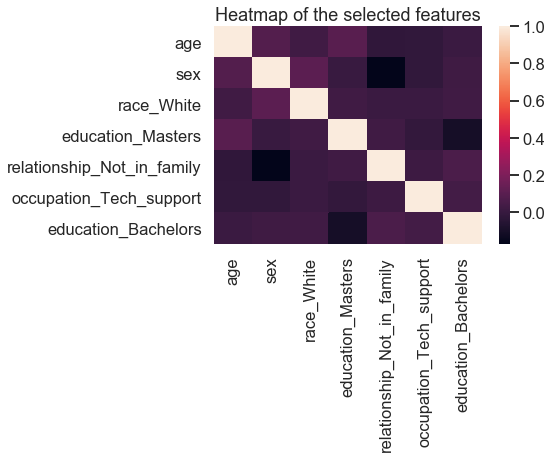

In [22]:
corr = df[predictors].corr()
hm = sns.heatmap(corr)
plt.title("Heatmap of the selected features")
plt.show(hm)

This heatmap shows that there are little to no correalation between the selected features which is needed for Naïve Bayes to work properly.

#### Creating and training the model

Next step is to create the training and test data, then model and make predictions.

In [23]:
X = df1.values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [24]:
print("Baseline accuracy: {:.2f}".format(1-y_train.mean()))
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
print("Naïve Bayes accuracy: {:.2}".format(clf.score(X_test, y_test)))

Baseline accuracy: 0.75
Naïve Bayes accuracy: 0.77


With the selected features we can see an increase of 2 percentage points on predictions with these selected features.

#### Confusion matrix

In [25]:
print_conf_mtx(y_test, y_pred, ["<=50K", ">50K"])

       predicted 
actual <=50K >50K
<=50K   6149  615
>50K    1474  811


The confusion matrix shows that the model are predicting relatively good on the people below \\$50K, but not that good on those with an income above \\$50K. This does also make sense to a degree since there are much more data on those with an income below \\$50K.

#### Precision and recall

In [26]:
print("Precision: {:.2f} Recall: {:.2f}"
      .format(precisionAndRecall(y_test, y_pred)[0], precisionAndRecall(y_test, y_pred)[1]))

Precision: 0.57 Recall: 0.35


The precision are pretty low with 57% which tells that the model is not really good at prediction, it only predicts right just above the half of the times. For the recall which is really bad, tells that the model is really bad at predicting the people with an actual income above \\$50K.

#### Learning Curve

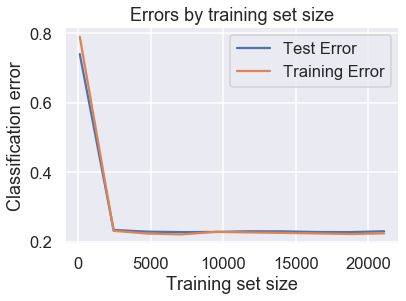

In [27]:
print_learningCurve(clf, X_train, X_test, y_train, y_test)

This learning curve is quite surprising. There is huge error for both training and test data in the beginning and then it quickly drops down to around .23 after 2500 rows of data. Then they are really close to each other for rest of the dataset. To me this is unclear if it is a high variance or bias situation.

#### ROC / AUC

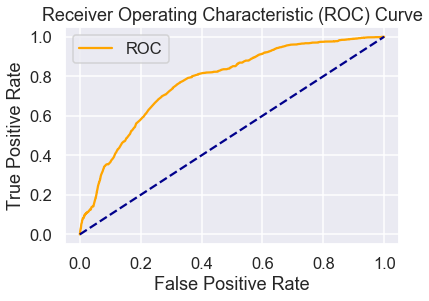

In [28]:
probs = clf.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [29]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.77


From this plot we can see that the model is not really great from the yellow graph in the plot, also the AUC is not that great.

# Model 2

#### Features

For this model, we are going to use feature forward selection algorithm to select the 10 *best* features to predict income.

In [30]:
df2 = df.drop(columns=["label"])
X = df2.values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [31]:
features = df2.columns[getBestFeaturesCV(X_train, y_train)]

num features: 1; accuracy: 0.79; 
num features: 2; accuracy: 0.79; 
num features: 3; accuracy: 0.79; 
num features: 4; accuracy: 0.80; 
num features: 5; accuracy: 0.80; 
num features: 6; accuracy: 0.80; 
num features: 7; accuracy: 0.81; 
num features: 8; accuracy: 0.81; 
num features: 9; accuracy: 0.81; 
num features: 10; accuracy: 0.82; 
num features: 11; accuracy: 0.82; 
num features: 12; accuracy: 0.82; 
num features: 13; accuracy: 0.82; 
num features: 14; accuracy: 0.83; 
num features: 15; accuracy: 0.83; 
num features: 16; accuracy: 0.83; 
num features: 17; accuracy: 0.83; 
num features: 18; accuracy: 0.83; 
num features: 19; accuracy: 0.83; 
num features: 20; accuracy: 0.83; 
num features: 21; accuracy: 0.83; 
num features: 22; accuracy: 0.84; 
num features: 23; accuracy: 0.84; 


From the forward feature selection algorithm, the highest accuracy is 84% before with 22 features. The *best* features are the following:

In [32]:
bestFeatures = features[:22]
for feature in bestFeatures:
    print(feature)

capital_gain
capital_loss
marital_status_Married_civ_spouse
education_Prof_school
marital_status_Never_married
age
education_Masters
education_num
education_Doctorate
workclass_Self_emp_inc
relationship_Not_in_family
occupation_Exec_managerial
education_Bachelors
relationship_Own_child
relationship_Wife
occupation_Other_service
occupation_Prof_specialty
sex
hours_per_week
occupation_Machine_op_inspct
relationship_Unmarried
education_HS_grad


#### Creating and training the model

Now we can build a new model with the *optimal* features.

In [33]:
X = df[bestFeatures].values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [34]:
print("Baseline accuracy: {:.2f}".format(1-y_train.mean()))
clf = GaussianNB()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)
print("Naïve Bayes accuracy: {:.2}".format(clf.score(X_test, y_test)))

Baseline accuracy: 0.75
Naïve Bayes accuracy: 0.83


Here we can see a good increase in accuracy, with 8 percentage points. This is almost as good as the accuracy on the training data, which can be a good indicator.

#### Confusion matrix

In [35]:
print_conf_mtx(y_test, y_pred, ["<=50K", ">50K"])

       predicted 
actual <=50K >50K
<=50K   6186  578
>50K     935 1350


This confusion matrix shows that the model are predicting pretty decent of the people with an income below \\$50K. Still it is not that great on the people above \\$50K, but it has increased greatly from the previous model and still makes sense due to the amount of data with people above \\$50K.

#### Precision and recall

In [36]:
print("Precision: {:.2f} Recall: {:.2f}"
      .format(precisionAndRecall(y_test, y_pred)[0], precisionAndRecall(y_test, y_pred)[1]))

Precision: 0.70 Recall: 0.59


Looking at precision and recall, we now have increased in both by a great amount. 70% of the predictions are now correct of the positive predictions while of all the true positive cases the model has predicted 59% of the cases as positive.

#### Learning Curve

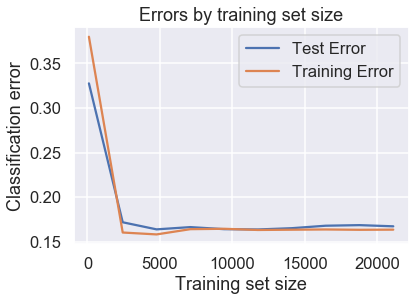

In [37]:
print_learningCurve(clf, X_train, X_test, y_train, y_test)

This learning curve have the same trend as for the previous model. It is still quite surprising how the graph looks. The most obvious differences is that the errors are much smaller to begin with and gets a lower error rate and the test data needs more data, around 5000 rows, for this model in order to get at a level where the training data is.

#### ROC / AUC

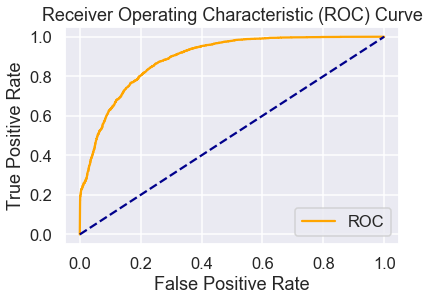

In [38]:
probs = clf.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [39]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.89


This model gives a much better ROC curve than the previous model. We can also see a significant increase for the area under curve (AUC) from 77 to 89.

# Model 3

#### Features

For this model the features from the forward feature selection algorithm will be used. The model of choice will be logisitc regression.

In [40]:
df3 = df.drop(columns=["label"])
X = df3.values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [41]:
features3 = df3.columns[getBestFeaturesLogCV(X_train, y_train)]

num features: 1; accuracy: 0.79;
num features: 2; accuracy: 0.80;
num features: 3; accuracy: 0.81;
num features: 4; accuracy: 0.81;
num features: 5; accuracy: 0.84;
num features: 6; accuracy: 0.84;
num features: 7; accuracy: 0.84;
num features: 8; accuracy: 0.84;
num features: 9; accuracy: 0.85;
num features: 10; accuracy: 0.85;


From the forward feature selection algorithm the best accuracy is at 85% with 9 features. The selected features are:

In [42]:
bestFeatures3 = features3[:9]
for feature in bestFeatures3:
    print(feature)

capital_gain
capital_loss
education_Masters
marital_status_Married_civ_spouse
education_num
occupation_Exec_managerial
workclass_Self_emp_not_inc
occupation_Farming_fishing
occupation_Other_service


#### Creating and training the model

In [43]:
X = df[bestFeatures3].values
y = df["label"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [44]:
print("Baseline accuracy: {:.2f}".format(1-y_train.mean()))
clf3 = LogisticRegression()
clf3.fit(X_train, y_train)
y_pred = clf3.predict(X_test)
y_prob = clf3.predict_proba(X_test)
print("Logistic regression accuracy: {:.2}".format(clf3.score(X_test, y_test)))

Baseline accuracy: 0.75
Logistic regression accuracy: 0.84


For the logistic model, we have an increase of 9 percent points in accuracy with *only* 9 features.

#### Confusion matrix

In [45]:
print_conf_mtx(y_test, y_pred, ["<=50K", ">50K"])

       predicted 
actual <=50K >50K
<=50K   6258  506
>50K     961 1324


The confusion matrix shows that we have pretty decent prediction rate for those with an income below \\$50K while it has not that great on the people below \\$50K.

#### Precision and recall

In [46]:
print("Precision: {:.2f} Recall: {:.2f}"
      .format(precisionAndRecall(y_test, y_pred)[0], precisionAndRecall(y_test, y_pred)[1]))

Precision: 0.72 Recall: 0.58


For this model we now have a precision and recall at 72% and 58% respectively, which is an increase of precision by 2 percentage points and a decrease by 1 percentage point of recall compared to the best Naïve Bayes model.

#### Learning curve

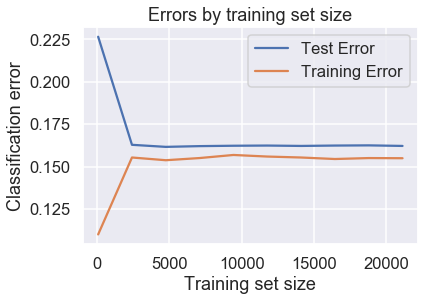

In [47]:
print_learningCurve(clf3, X_train, X_test, y_train, y_test)

As for the previous models it looks like we have a learning curve that shows that the model needs to have around 2500 rows of data to stabilize the error rate. This curve shows a trend towards a high bias situation.

#### ROC / AUC

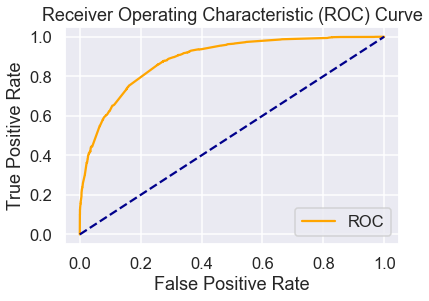

In [48]:
probs = clf3.predict_proba(X_test)
probs = probs[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, probs)
plot_roc_curve(fpr, tpr)

In [49]:
auc = roc_auc_score(y_test, probs)
print('AUC: %.2f' % auc)

AUC: 0.88


For this ROC curve we can see a similar trend to the model 2 curve. It is pretty good and we have a good AUC at 88.

# Conclusion

---

Selecting features in blindness is not easy for this project. With help of a heatmap I tried a lot of different features with low correaltion to beat baseline accuracy, the best result ended with an increase of 2 percentage points in accuracy. This model did not do really well on predictions on test data which was somewhat surprising with that accuracy.


As for the second model, using forward feature selection made a great increase in number of features and results. These predictions gave pretty good results on the cases where income is below \\$50K which also is desribed earlier in the report. The biggest challenge with this model is the predict correctly for people with an income above \\$50K.


For the last model I chose to use Logistic Regression in an attempt to do better than Naïve Bayes. Again by using forward feature selection, I ended up only using 9 features. By running the forward feature selection algorithm with cross validation it took a lot of computing resources, so I decided to stop the algorithm at 20 features. I could not see any accuracy increase after 9 features while it might be better with 20+ features.